# Graphing training loss

Imports

In [15]:
import numpy as np
import csv
from matplotlib import pyplot as plt
%matplotlib inline

Load the files containing the training loss that was logged during training.

In [8]:
logfilenames = (
    'traininglogs/fae000trainloss.ssv',
    'traininglogs/fae050trainloss.ssv',
    'traininglogs/fae090trainloss.ssv',
    'traininglogs/fvae000trainloss.ssv',
    'traininglogs/fvae050trainloss.ssv',
    'traininglogs/fvae090trainloss.ssv',
    'traininglogs/fvae100trainloss.ssv',
)
model_names = [
    "FAE λ0.0",
    "FAE λ0.5",
    "FAE λ0.9",
    "FVAE λ0.0",
    "FVAE λ0.5",
    "FVAE λ0.9",
    "FVAE λ1.0 (scaled by 10x)"
]
training_losses = []
for logfilename in logfilenames:
    with open(logfilename, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        training_losses += [np.array(tuple((int(epoch),float(loss)) for epoch,loss in spamreader))]


Plot training loss on a log scale.

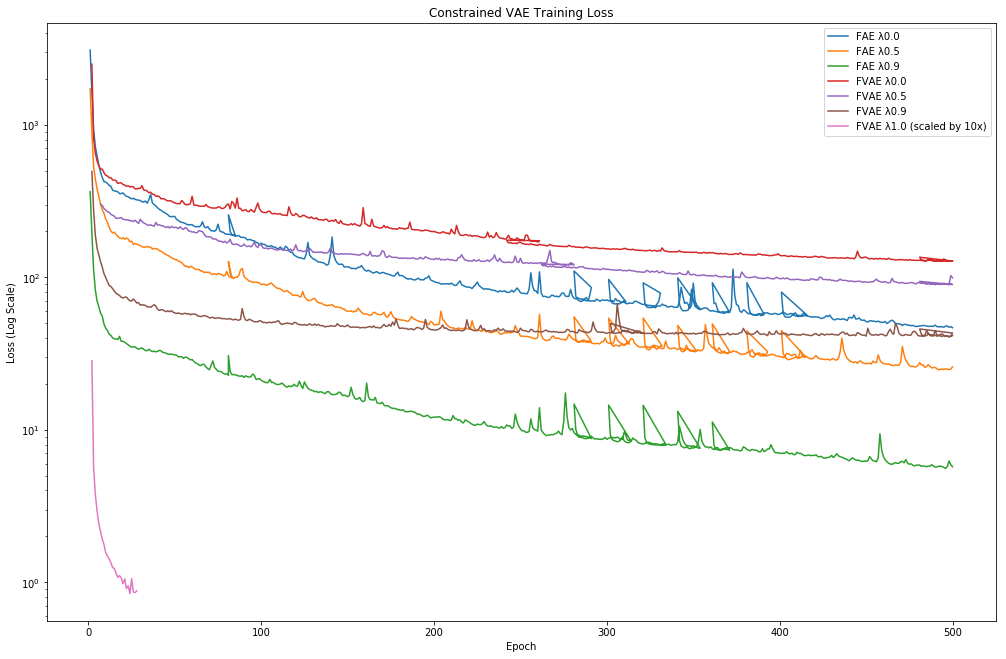

In [11]:

plt.rcParams["figure.figsize"] = (17,11)

plts = []
for tl in training_losses:
    plts+=[plt.plot(tl[:,0],tl[:,1])]

plt.yscale('log')
plt.ylabel('Loss (Log Scale)')
plt.xlabel('Epoch')
#plt.legend([plt000,plt050,plt090,plt100],["λ0.0","λ0.5","λ0.9","λ1.0"])
plt.legend(model_names)
plt.title("Constrained VAE Training Loss")
plt.show()

The higher lambda corrisponds to lower losses. This is likely due to the KL divergence loss limiting the amount Z will vary compared to X.

The triangle loop things on the FAE training loss models are interuptions due to slurm. Oddly enough, every time there was an interruption there was a much higher loss for an epoch or two upon it resuming. Interruptions to the FVAE model don't seem to show this effect. I don't think it's worth investigating right now, but I'd be interested to hear any speculation or insight.

The training losses are all in respect to their own loss functions. It might be informative to look at the different addends from each of the loss functions used on their own.

## Training loss from checkpoints

#### Setup

import torch and the models.

In [2]:
import torch
import fishae
import fishvae

In [3]:
aeModel = torch.nn.DataParallel(fishae.FishAE())
aeModel.eval()
vaeModel = torch.nn.DataParallel(fishvae.FishVAE())
vaeModel.eval()

DataParallel(
  (module): FishVAE(
    (encoder): Encoder(
      (main): Sequential(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): LeakyReLU(negative_slope=0.2, inplace=True)
        (11): Conv2d(1024, 2048,

Load the mvtec dataset and tqdm for progress bars and random for selecting sample of dataset.

In [4]:
MVTEC_ROOT_DIR = "/scratch/ssd002/datasets/MVTec_AD"
from vector_cv_tools import transforms as VT
import albumentations as A
from albumentations.pytorch import ToTensorV2
from vector_cv_tools import datasets as vdatasets

from tqdm.notebook import tqdm
from random import seed, sample

basic_transform = VT.ComposeMVTecTransform([A.Resize(128, 128), A.ToFloat(max_value=255), ToTensorV2()])

In [5]:
from vector_cv_tools.datasets.mvtec import MVTec_OBJECTS

In [6]:
dsets = list(vdatasets.MVTec(MVTEC_ROOT_DIR, split="train", transforms = basic_transform,
                             obj_types=[obj_type]) for obj_type in MVTec_OBJECTS)

In [7]:
for ob_name, dset in zip(MVTec_OBJECTS,dsets):
    print(f"There are {len(dset)} {ob_name}s here.")

There are 209 bottles here.
There are 224 cables here.
There are 219 capsules here.
There are 280 carpets here.
There are 264 grids here.
There are 391 hazelnuts here.
There are 245 leathers here.
There are 220 metal_nuts here.
There are 267 pills here.
There are 320 screws here.
There are 230 tiles here.
There are 60 toothbrushs here.
There are 213 transistors here.
There are 247 woods here.
There are 240 zippers here.


A little pre processing seems to be required here in order to efficiently process all the samples with each model.
I've chosen to take 32 samples from each object type. I use a seed so that it will be the same samples each time it is run to not introduce extra noise into comparisons.

This pulls just the image portion of each sample and then performes the subsampling. It would be faster to subsample first, but the sample function doesn't accept the dataset for whatever reason.

=Warning: slow=

In [8]:
samples_per_ob = 32

In [24]:
seed(42)
samples = []
for dset in tqdm(dsets):
    dset_img = list(x[0] for x in dset)
    samples+= sample(dset_img,samples_per_ob)


Move image samples into pytorch

In [25]:
unsq_samples = []
for sample in tqdm(samples):
    unsq_samples+=[sample.unsqueeze(0)]

In [26]:
X = torch.cat(unsq_samples,0).cuda()

In [27]:
print(X.size())

torch.Size([480, 3, 128, 128])


Helper functions for doing decoding and encoding and for loading models.

In [28]:
def imgs2vecs(model,img):
    with torch.no_grad():
        z = model.module.encoder(img)
    return z[..., :100] # we only like mu
def vecs2imgs(model,vec):
    with torch.no_grad():
        img = model.module.decoder(vec.unsqueeze(-1).unsqueeze(-1))
    return img

In [29]:
def loadmodel(given_filename):
    """Tool for loading checkpoints which are spread across 4 different directories"""
    root = "/checkpoint/ttrim/"
    
    if "vae" in given_filename:
        subdir = ("fvae_pt1/",
                  "fvae_pt2/",
                 )
        
        for di in subdir:
            filename = root+di+given_filename
            try:
                vaeModel.load_state_dict(torch.load(filename))
                return vaeModel
            except FileNotFoundError:
                pass
        raise FileNotFoundError(f"couldn't find {filename}")
    else:
        subdir = ("fae_pt1/",
                  "fae_pt2/",
                 )
        
        for di in subdir:
            filename = root+di+given_filename
            try:
                aeModel.load_state_dict(torch.load(filename))
                return aeModel
            except FileNotFoundError:
                pass
        raise FileNotFoundError(f"couldn't find {filename}")
    

#### Evaluation

Go through each checkpoint and get the X and Z losses for our given subsamples.

=Warning: Slow= Takes 15 - 30 minutes to complete for full set of checkpoints.

In [ ]:

#mode = "debug"
#mode = "small"
mode = "full"

if mode=="debug":
    frills = ("ae",)
    lmdas = ("0.0",)
    epochs = ("500",)
elif mode == "small":
    frills = ("ae","vae")
    lmdas = ("0.0","0.5","0.9")
    epochs = ("1","5","20","100","500")
elif mode == "full":
    frills = ("ae","vae")
    lmdas = ("0.0","0.5","0.9")
    epochs = ("1","2","3","5","8","13","20","40","60","80","100","120","140",
              "160","180","200","220","240","260","280","300","320","340","360",
              "380","400","420","440","460","480","500",)
else:
    raise

losses = {}

for frill in tqdm(frills):
 losses[frill] = {}
 for lmda in tqdm(lmdas, leave=False):
  losses[frill][lmda] = {
      "x":[],
      "z":[]
  }
  for ob in MVTec_OBJECTS:
        losses[frill][lmda][ob] = {
                  "x":[],
                  "z":[]
        }
  for epoch in tqdm(epochs, leave=False):
    model_file = f"fish{frill}_v1_lmda{lmda}_epo{epoch}.pt"
    model = loadmodel(model_file)
    
    Z = imgs2vecs(model,X)
    Xr = vecs2imgs(model,Z)
    Zr = imgs2vecs(model,Xr)

    X = X.cuda()
    Z = Z.cuda()
    Xr = Xr.cuda()
    Zr = Zr.cuda()
    
    for i,ob in enumerate(MVTec_OBJECTS):
        start_index = i*samples_per_ob
        stop_index = (i+1)*samples_per_ob
        ob_X = X[start_index:stop_index, ..., ..., ...]
        ob_Z = Z[start_index:stop_index, ..., ..., ...]
        ob_Xr = Xr[start_index:stop_index, ..., ..., ...]
        ob_Zr = Zr[start_index:stop_index, ..., ..., ...]
        
        ob_xloss = (ob_X-ob_Xr).pow(2).sum() / samples_per_ob
        ob_zloss = (ob_Z-ob_Zr).pow(2).sum() / samples_per_ob
        
        losses[frill][lmda][ob]["x"] += [[epoch,float(ob_xloss)]]
        losses[frill][lmda][ob]["z"] += [[epoch,float(ob_zloss)]]
    
    B = X.size(0)
    
    xloss = (X-Xr).pow(2).sum() / B
    zloss = (Z-Zr).pow(2).sum() / B

    losses[frill][lmda]["x"] += [[epoch,float(xloss)]]
    
    losses[frill][lmda]["z"] += [[epoch,float(zloss)]]


### Plot results!

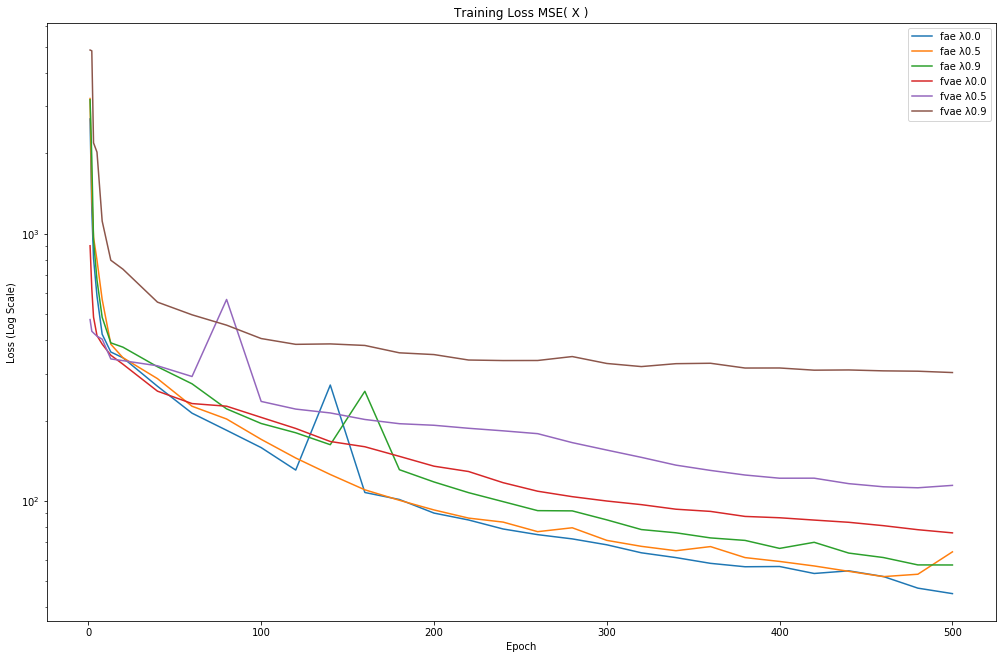

In [15]:
plt.rcParams["figure.figsize"] = (17,11)

plts = []
pltnames = []
for frill in tqdm(frills):
 for lmda in tqdm(lmdas, leave=False):
    pltnames += [f"f{frill} λ{lmda}"]
    plts+=[plt.plot(
            list(int(x[0]) for x in losses[frill][lmda]["x"]),
            list(float(x[1]) for x in losses[frill][lmda]["x"]),
        )]

plt.yscale('log')
plt.ylabel('Loss (Log Scale)')
plt.xlabel('Epoch')
plt.legend(pltnames)
plt.title("Training Loss MSE( X )")
plt.show()

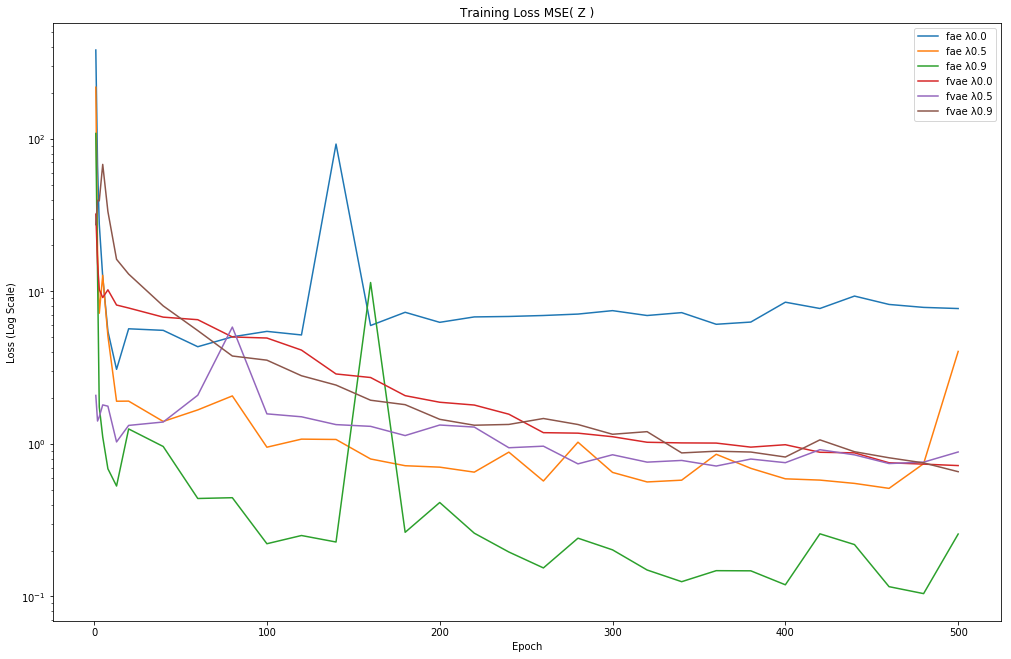

In [16]:
plt.rcParams["figure.figsize"] = (17,11)

plts = []
pltnames = []
for frill in tqdm(frills):
 for lmda in tqdm(lmdas, leave=False):
    pltnames += [f"f{frill} λ{lmda}"]
    plts+=[plt.plot(
            list(int(x[0]) for x in losses[frill][lmda]["z"]),
            list(float(x[1]) for x in losses[frill][lmda]["z"]),
        )]

plt.yscale('log')
plt.ylabel('Loss (Log Scale)')
plt.xlabel('Epoch')
plt.legend(pltnames)
plt.title("Training Loss MSE( Z )")
plt.show()

In [18]:
losses ## just whole dataset

{'ae': {'0.0': {'x': [['1', 2692.73193359375],
    ['2', 1232.7337646484375],
    ['3', 809.84716796875],
    ['5', 585.5125122070312],
    ['8', 421.0570068359375],
    ['13', 361.35498046875],
    ['20', 343.8211975097656],
    ['40', 268.955810546875],
    ['60', 213.2677459716797],
    ['80', 184.02110290527344],
    ['100', 158.51634216308594],
    ['120', 130.61972045898438],
    ['140', 271.82635498046875],
    ['160', 107.65090942382812],
    ['180', 101.3425521850586],
    ['200', 90.16011047363281],
    ['220', 84.96139526367188],
    ['240', 78.61080932617188],
    ['260', 74.86267852783203],
    ['280', 72.17793273925781],
    ['300', 68.59284210205078],
    ['320', 64.02288055419922],
    ['340', 61.433746337890625],
    ['360', 58.460819244384766],
    ['380', 56.76826477050781],
    ['400', 56.887657165527344],
    ['420', 53.57310485839844],
    ['440', 54.80227279663086],
    ['460', 52.19783020019531],
    ['480', 47.210357666015625],
    ['500', 45.0343132019043]],
 

In [52]:
losses ## with each object

{'ae': {'0.0': {'bottle': {'x': [['1', 5566.5458984375],
     ['2', 1437.5322265625],
     ['3', 653.9794921875],
     ['5', 303.0865478515625],
     ['8', 181.64364624023438],
     ['13', 143.12295532226562],
     ['20', 127.80902099609375],
     ['40', 95.31340026855469],
     ['60', 83.85441589355469],
     ['80', 75.49938201904297],
     ['100', 70.19940948486328],
     ['120', 60.72672653198242],
     ['140', 108.17097473144531],
     ['160', 54.63329315185547],
     ['180', 56.99026107788086],
     ['200', 50.941734313964844],
     ['220', 52.072635650634766],
     ['240', 45.42522430419922],
     ['260', 44.82817077636719],
     ['280', 44.043067932128906],
     ['300', 42.83943176269531],
     ['320', 43.69549560546875],
     ['340', 40.58985900878906],
     ['360', 40.66777801513672],
     ['380', 39.80228042602539],
     ['400', 41.14262390136719],
     ['420', 38.954315185546875],
     ['440', 40.06619644165039],
     ['460', 39.65373992919922],
     ['480', 36.5617141723632

In [11]:
# Rather than recalculating, import the above losses!
from traininglogs.precalc_losses_fvae_and_fae import losses

In [12]:
import seaborn as sb
custom_lines = [plt.Line2D([0], [0], color=sb.color_palette()[x], lw=4) for x in range(5)]

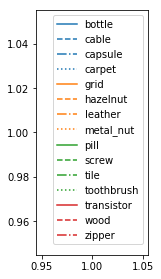

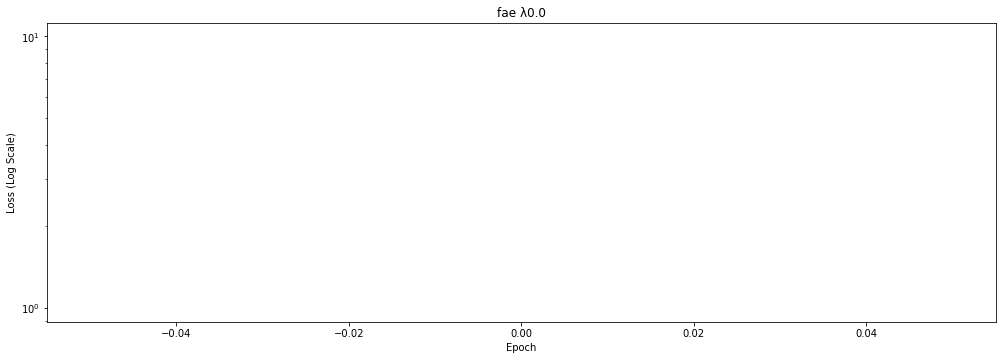

KeyError: '0.5'

In [21]:
cm = sb.color_palette()
NUM_COLORS = len(cm)
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)

#cm = plt.get_cmap('gist_rainbow')
#fig = plt.figure()
#ax = fig.add_subplot(111)
#for i in range(NUM_COLORS):
#    lines = ax.plot(np.arange(10)*(i+1))
#    lines[0].set_color(cm(i//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))
#    lines[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])

plts = []

color_index = 0
plt.rcParams["figure.figsize"] = (2,4.5)
for ob in MVTec_OBJECTS:
    #pltnames += [f"f{frill} λ{lmda}"]
    plts+=[plt.plot(
            list([1,1]),
            list([1,1]),
        )]
    
    plts[-1][0].set_color(cm[int(color_index/NUM_STYLES)%NUM_COLORS])
    plts[-1][0].set_linestyle(LINE_STYLES[color_index%NUM_STYLES])
    color_index+=1
    
plt.legend(MVTec_OBJECTS)
plt.show()

plt.rcParams["figure.figsize"] = (17,5.5)

pltnames = []
for frill in tqdm(frills):
 for lmda in tqdm(lmdas, leave=False):
    
    color_index = 0
    
    for ob in MVTec_OBJECTS:
        #pltnames += [f"f{frill} λ{lmda}"]
        plts+=[plt.plot(
                list(int(x[0]) for x in losses[frill][lmda][ob]["x"]),
                list(float(x[1]) for x in losses[frill][lmda][ob]["x"]),
            )]
        
        plts[-1][0].set_color(cm[int(color_index/NUM_STYLES)%NUM_COLORS])
        plts[-1][0].set_linestyle(LINE_STYLES[color_index%NUM_STYLES])
        
        color_index+=1

    plt.yscale('log')
    plt.ylabel('Loss (Log Scale)')
    plt.xlabel('Epoch')
    #plt.legend(MVTec_OBJECTS)
    plt.title(f"f{frill} λ{lmda}")
    plt.show()